# Initialization

In [1]:
%matplotlib inline

from os import listdir, mkdir, path

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [2]:
example_dir = '../../../build/examples/geometry/parametrization_breakdown'
results_dir = path.join(example_dir, 'results')

In [3]:
result_files = listdir(results_dir)

In [4]:
def poly_coeffs(x, coeffs):
    order = len(coeffs)                                                            
    y = 0                                                                          
                                                                                   
    for i in range(order):                                                         
        y += coeffs[i]*x**(order-(i+1))                                            
                                                                                   
    return y

In [5]:
def load_visualization_files(geom_name):
    coords = np.loadtxt(path.join(results_dir, f'{geom_name}_coords.csv'), delimiter=',')
    points = np.loadtxt(path.join(results_dir, f'{geom_name}_points.csv'), delimiter=',')
    
    child_files = [
        path.join(results_dir, file) for file in listdir(results_dir) if (geom_name in file and 'child' in file)
    ]
    
    # remove degenerate files
    if geom_name in ['tria', 'quad']:
        child_files = [
            child_file for child_file in child_files if 'degenerate' not in child_file
        ]
    
    child_coords = [
        np.loadtxt(file, delimiter=',') for file in sorted(child_files) if 'coords' in file
    ]
    child_points = [
        np.loadtxt(file, delimiter=',') for file in sorted(child_files) if '_points' in file
    ]
    
    return coords, points, child_coords, child_points

In [6]:
def load_determinant_files(geom_name):
    ref_points = np.loadtxt(path.join(results_dir, f'{geom_name}_refpoints.csv'), delimiter=',')
    determinants = np.loadtxt(path.join(results_dir, f'{geom_name}_jacdets.csv'), delimiter=',')
    
    child_files = [
        path.join(results_dir, file) for file in listdir(results_dir) if (geom_name in file and 'child' in file)
    ]
    
    # remove degenerate quad files
    if geom_name in ['tria', 'quad']:
        child_files = [
            child_file for child_file in child_files if 'degenerate' not in child_file
        ]
    
    child_ref_points = [
        np.loadtxt(file, delimiter=',') for file in sorted(child_files) if 'refpoints' in file
    ]
    child_determinants = [
        np.loadtxt(file, delimiter=',') for file in sorted(child_files) if 'jacdet' in file
    ]
    
    return ref_points, determinants, child_ref_points, child_determinants

In [7]:
def extract_coordinates(coords):
    num_vertices = int(coords.shape[1] / 2)
    
    vertices_x = coords[0, :num_vertices]
    vertices_y = coords[1, :num_vertices]
    midpoints_x = coords[0, num_vertices:]
    midpoints_y = coords[1, num_vertices:]
    
    return vertices_x, vertices_y, midpoints_x, midpoints_y

In [8]:
def plot_geom(ax, coords):
    vertices_x, vertices_y, midpoints_x, midpoints_y = extract_coordinates(coords)
    
    for x, y in zip(vertices_x, vertices_y):
        ax.plot(x, y, 'k*', linewidth=2, label='vertex')
        
    for x, y in zip(midpoints_x, midpoints_y):                                            
        ax.plot(x, y, 'r*', linewidth=2, label='midpoint')
        
    num_vertices = vertices_x.shape[0]
    
    for i in range(num_vertices):                                                                 
        coeffs = np.polyfit(                                                           
            [vertices_x[i], midpoints_x[i], vertices_x[(i+1)%num_vertices]],
            [vertices_y[i], midpoints_y[i], vertices_y[(i+1)%num_vertices]],                            
            2                                                                          
        )                                                                              
                                                                                   
        x = np.linspace(vertices_x[i], vertices_x[(i+1)%num_vertices], 1000)                      
        ax.plot(x, poly_coeffs(x, coeffs), color='g')

In [9]:
def visualize_geom(geom_name):
    coords, points, child_coords, child_points = load_visualization_files(geom_name)
    
    fig, ax = plt.subplots(
        1, 1 + len(child_coords), sharex='all', sharey='all', figsize=(3*len(child_coords), 3)
    )
    
    ax[0].set_title('original')
    plot_geom(ax[0], coords)
    ax[0].scatter(points[0, :], points[1, :], s=0.5)

    for child, (coords, points) in enumerate(zip(child_coords, child_points)):
        ax[child + 1].set_title(f'child {child}')
        plot_geom(ax[child + 1], coords)
        ax[child + 1].scatter(points[0, :], points[1, :], s=0.5)                                             
    
    plt.legend()

In [10]:
def check_volumes(geom_name):
    volumes = np.loadtxt(path.join(results_dir, f'{geom_name}_volumes.csv'), delimiter=',')
    
    print('original volume:', volumes[0])
    print('refined volume: ', volumes[1])

In [11]:
class MidpointNormalize(colors.Normalize):
    """
    Normalize the colorbar so that diverging bars work there way either side from a prescribed midpoint value
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [12]:
def plot_jacobian_determinants(ax, ref_points, determinants, extrema):
    scat = ax.scatter(
        ref_points[0, :], ref_points[1, :],
        c=determinants, cmap=cm.coolwarm, clim=extrema, 
        norm=MidpointNormalize(midpoint=0, vmin=extrema[0], vmax=extrema[1])
    )
    ax.axis('off')
    
    return scat

In [13]:
def visualize_jacobian_determinants(geom_name):
    ref_points, determinants, child_ref_points, child_determinants = load_determinant_files(geom_name)
    
    max_val = max(map(max, [determinants] + child_determinants))
    min_val = min(map(min, [determinants] + child_determinants))
    extrema = (min(min_val, 0), max(max_val, 0))
    
    fig, ax = plt.subplots(
        1, 1 + len(child_ref_points), sharex='all', sharey='all', figsize=(3*len(child_ref_points), 3)
    )
    
    ax[0].set_title('original')
    plot_jacobian_determinants(ax[0], ref_points, determinants, extrema)
    
    for child, (ref_points, determinants) in enumerate(zip(child_ref_points, child_determinants)):
        ax[child + 1].set_title(f'child {child}')
        scat = plot_jacobian_determinants(ax[child + 1], ref_points, determinants, extrema)
    
    cax, kw = mpl.colorbar.make_axes([axis for axis in ax.flat], fraction=0.0175, aspect=10)
    plt.colorbar(scat, cax=cax, **kw)

# Investigate Parametrization Breakdown

original volume: 15.4333
refined volume:  15.4333


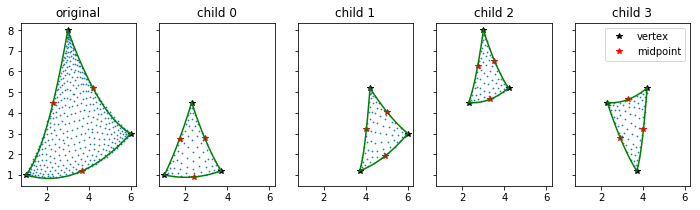

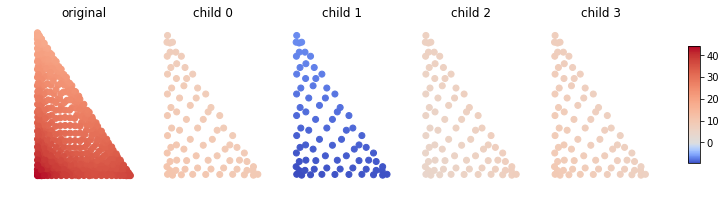

In [14]:
visualize_geom('tria')
check_volumes('tria')
visualize_jacobian_determinants('tria')

original volume: 22.5639
refined volume:  22.5579


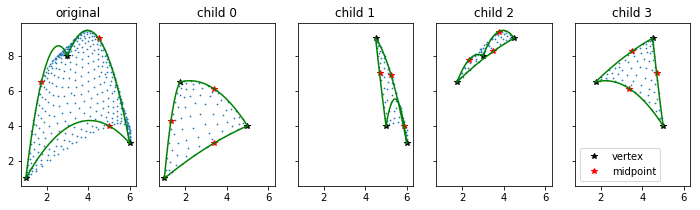

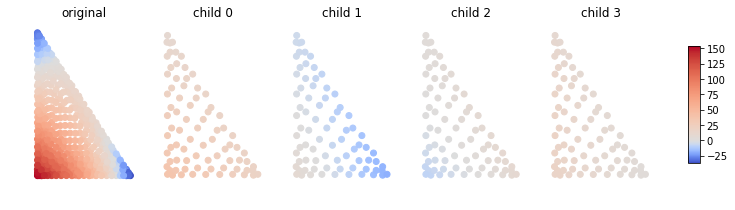

In [15]:
visualize_geom('tria_degenerate')
check_volumes('tria_degenerate')
visualize_jacobian_determinants('tria_degenerate')

original volume: 20.9667
refined volume:  20.9667


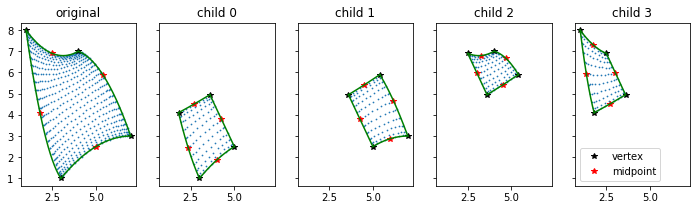

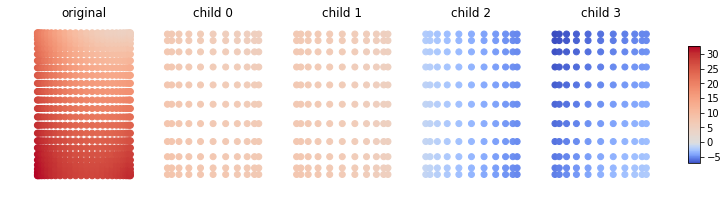

In [16]:
visualize_geom('quad')
check_volumes('quad')
visualize_jacobian_determinants('quad')

original volume: 26.9789
refined volume:  26.9915


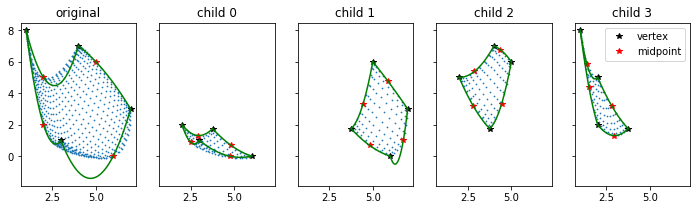

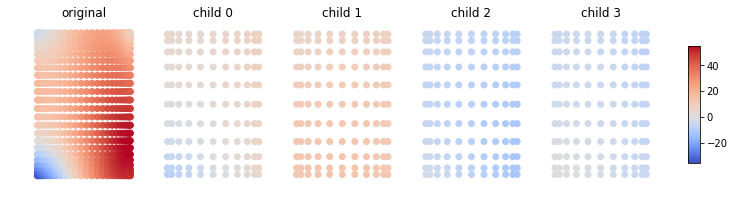

In [17]:
visualize_geom('quad_degenerate')
check_volumes('quad_degenerate')
visualize_jacobian_determinants('quad_degenerate')